# Information Retrieval Project - ResNet50 model implementation
## COVID-19 Search Engine (P12)

Content-based image retrieval (CBIR) is a computer vision technique which addresses the problem of searching for digital images in large databases. A content-based approach exploits the contents of an image, such as colors, shapes and textures, differing from its concept-based counterpart, which instead focuses on keywords and tags associated with the image itself.

Image retrieval has gained more and more relevance in the medical field, due to the accumulation of extensive collections of scans in hospitals. These images are stored in DICOM format, which must be manually annotated and may require considerable time to process by physicians. The goal of this project is trying to address this problem by considering different approaches for building a content-based medical image retrieval system and comparing their results based on classification metrics and computational time.

# Installation of Requirements

This part of the code installs necessary dependencies specified in the `requirements.txt` file.
Utilizes the `!pip install -r requirements.txt` command to install packages listed in the `requirements.txt` file. This ensures that all required dependencies are installed before proceeding with execution.


In [ ]:
!pip install -r requirements.txt

# Importing Required Libraries

This part of the code imports necessary libraries.

In [2]:
# Import
import os
import time
import glob
import keras
import kaggle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from keras.models import Model
from keras.layers import Dense, Flatten
from keras.utils import load_img, img_to_array
from keras.applications.resnet import ResNet50, preprocess_input

from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score


# Definition of constants

This part of the code defines useful constants.

In [3]:
# ************************************** #
# ************** CONSTANTS ************* #
# ************************************** #

# PATHS
PROJECT_ROOT = os.getcwd()  # The project root
DATASET_PATH = "archives"  # Path to the dataset
DATASET_ID = "plameneduardo/sarscov2-ctscan-dataset"  # ID for Kaggle API. Format: dataset_owner_name/dataset_name
COVID_PATH = os.path.join(DATASET_PATH, "COVID")  # Path to data labeled as COVID
NON_COVID_PATH = os.path.join(DATASET_PATH, "non-COVID")  # Path to data labeled as non-COVID
DATA_PATH = "data"  # Path to the data folder 
PLOT_PATH = "plot"  # Path to the plot folder
RESNET50_TRAIN_JSON = os.path.join(DATA_PATH, f"resnet50_train_data.json")  # Path to Training indexed data
RESNET50_TEST_JSON = os.path.join(DATA_PATH, f"resnet50_test_data.json")  # Path to Test indexed data


# DATA RELATED
CLASSES = ["COVID", "non-COVID"]
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
CHANNELS = 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

# SIMILARITY RELATED
COSINE = "Cosine" 
SIMILARITY_THRESHOLD = 0.5  # A similarity score above this threshold is considered a relevant (similar) image for the query image.
TOP_N = 20  # Number of images retrieved
RELEVANT_PICK = 5  # Number of RELEVANT images picked by relevance feedback process
IRRELEVANT_PICK = 3  # Number of IRRELEVANT images picked by relevance feedback process

# ROCCHIO's ALGORITHM WEIGHTS
ALPHA = 1
BETA = 0.75
GAMMA = 0.15


# Defining the Workspace

Download the dataset and define usefull directory to store data and plot.

## Function: `download_dataset_from_kaggle`

### Description:
This function downloads the specified dataset from the Kaggle website using the Kaggle module. It checks if the dataset already exists in the specified location and downloads it if not present. Additionally, it unzips the downloaded dataset.

### Workspace Operations:
1. **Create Data Folder**: A data folder is created at the location specified by `DATA_PATH`, if it does not already exist.
2. **Create Plot Folder**: A plot folder is created at the location specified by `PLOT_PATH`, if it does not already exist.


In [ ]:
# Download dataset from Kaggle website
def download_dataset_from_kaggle(dataset_id: str, dataset_path: str) -> None:
    """
    Download the sarscov2-ctscan-dataset using Kaggle module

    :param dataset_id: identify the dataset to download.
        Format: dataset_owner_name/dataset_name
    :param dataset_path: location to save the dataset

    :return: None
    """
    # Download the dataset if not exist in the workplace
    if not os.path.exists(path=dataset_path):
        
        print("\n> Download the dataset from Kaggle...")
        # Download dataset and unzip it
        kaggle.api.dataset_download_files(dataset=dataset_id, path=dataset_path, quiet=False, unzip=True)
    else:
        print("\n> Dataset already downloaded.")


## ************************************ DEFINING THE WORKSPACE ********************************** ##      


# Execute the download operation
download_dataset_from_kaggle(dataset_id=DATASET_ID, dataset_path=DATASET_PATH)

# Create data folder
os.makedirs(DATA_PATH, exist_ok=True)

# Create plot folder
os.makedirs(PLOT_PATH, exist_ok=True)


# Dataset Preprocessing Summary

dataset management and pre-processing tasks.

## Function: `count_files`

### Description:
This function counts the number of files with specified extensions in the specified directory. It iterates over the directory and checks each file's extension against the provided list of extensions.

---

## Function: `print_file_counts`

### Description:
A helper function that prints information about the number of files inside the COVID and non-COVID directories.

---

### Function: `corruption_filter`

### Description:
This function checks the dataset for corrupted files and deletes them if requested. It finds all image files in the dataset, loops through each file, and attempts to open it using `PIL.Image.open()`. If an `UnidentifiedImageError` occurs, the file is considered corrupted.

---

## Function: `checking_dataset`

### Description:
This function performs a preliminary check on the dataset by calling `corruption_filter` to analyze and control the dataset for corrupted files.


In [5]:
# Count the number of files
def count_files(directory_path: str, extensions="png") -> int:
    """
    Count the number of files with specified extensions in the specified directory.

    Example: count_files("/path/to/directory", extensions=["jpg", "png"]) -> 12

    :param directory_path: (str) The path to the directory for which file count is required.
    :param extensions: (list or None) List of file extensions to count. If None, count all files.

    :return: (int) The number of files with specified extensions in the specified directory.
    """
    if extensions is None:
        # If no extensions provided, consider all files
        extensions = ['']
    
    # Initialize counter for files
    counter = 0 
    # Iterate over the directory
    with os.scandir(directory_path) as entries:
        for entry in entries:
             # Check if it's a file with specified extension
            if entry.is_file() and any(entry.name.lower().endswith(ext) for ext in extensions):
                counter += 1

    return counter


# Just a helper function
def print_file_counts() -> None:
    """
    A helper function that print information about the number of files inside the directory.
    
    :return: None
    """
    count_covid = count_files(directory_path=COVID_PATH)  # Count COVID files
    count_non_covid = count_files(directory_path=NON_COVID_PATH)  # Count non-COVID files
    
    # Total number of files
    tot_number_file = count_covid + count_non_covid
    # Print the counts
    print("- Total Number of file: {}\n".format(tot_number_file) +
          "- Number of file in COVID: {}\n".format(count_covid) +
          "- Number of file in non-Covid: {}\n".format(count_non_covid))
    

# Check dataset: filter out possible corrupted files.
def corruption_filter(dataset_path: str) -> None:
    """
    Check dataset for corrupted files and delete them if requested.

    :param dataset_path: The path to the dataset.
    
    :return: None
    """
    # Find all image files in the dataset
    image_files = glob.glob(os.path.join(dataset_path, "**", "*.png"), recursive=True)
    
    bad_files = []  # to store corrupted file
    
    # Loop 
    for image_file in image_files:
        try:
            with Image.open(image_file) as img:
                img.verify()
        except UnidentifiedImageError:
            bad_files.append(image_file)
            print("\n> There are {} corrupted files: {}".format(len(bad_files), bad_files))

    if len(bad_files) != 0:  # If there are corrupted files -> Delete them
        doc_message = input("\n> Do you want to delete these {} file? [Y/N]: ".format(len(bad_files)))
        if doc_message.upper() == "Y":
            for bad_file in bad_files:
                # Delete corrupted file
                os.remove(bad_file)
                # Print success message
                print("- {} Corrupted File Deleted Successfully!".format(bad_file))

            # Update file counts after removal of corrupted files
            print("\n> Checking the Number of file after the application of the corruption filter:")
            print_file_counts()
    else:  # If no corrupted files found
        print("> No Corrupted File Found")


# Pre-Processing Workflow
def checking_dataset(dataset_path: str) -> None:
    """
    Preliminary check on dataset:
        Calling corruption_filter, find_out_duplicate to analyze and control the dataset.
 
    :param dataset_path: The path to the dataset.
    
    :return: None
    """
    print("\n> CHECK THE DATASET")
    print("\n> Checking the Number of file before performing Pre-processing Task...")
    
    # Print count
    print_file_counts()
    
    # Check for corrupted file
    print("> Checking for corrupted files...")
    corruption_filter(dataset_path=dataset_path)
    
    print("\n> Final check to confirm the total file count:")
    print_file_counts()
    
    print("> DATASET CHECK COMPLETE!")


## ************************************ CHECKING THE DATASET ********************************** ##


# Execute Pre-Processing tasks on dataset 
checking_dataset(dataset_path=DATASET_PATH)



> CHECK THE DATASET

> Checking the Number of file before performing Pre-processing Task...
- Total Number of file: 2481
- Number of file in COVID: 1252
- Number of file in non-Covid: 1229

> Checking for corrupted files...
> No Corrupted File Found

> Final check to confirm the total file count:
- Total Number of file: 2481
- Number of file in COVID: 1252
- Number of file in non-Covid: 1229

> DATASET CHECK COMPLETE!


# Data Preparation

## Function 1: `build_dataframe`

### Description:
This function constructs a pandas DataFrame from a dataset stored at the specified path. It iterates over the directories in the dataset, appending file paths along with their corresponding class labels to a list.

---

## Function 2: `plot_class_distribution`

### Description:
This function generates a bar graph illustrating the distribution of classes within the provided DataFrame. It calculates the count of each class and plots a bar for each class, with color distinctions.

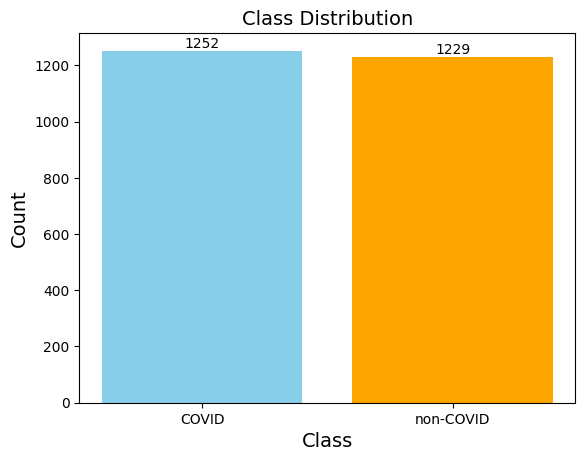

In [6]:
# Define a pandas dataframe
def build_dataframe(dataset_path: str) -> pd.DataFrame:
    """
    Build a dataframe from dataset
    
    :param dataset_path: Path to the dataset
    
    :return: dataset's dataframe.
    """
    data = []
    
    for class_label, directory_names in enumerate(CLASSES):
        # Folder path -> archives/COVID or archives/non-COVID
        folder_path = os.path.join(dataset_path, directory_names)  
        
        for file in os.listdir(folder_path):
            # File path -> example. archives/COVID/Covid (1).png
            file_path = os.path.join(folder_path, file)
            
            # Append file information along with class label to the data list
            data.append([file_path, class_label])
            
    # Create a DataFrame using the collected data with appropriate column name
    data_df = pd.DataFrame(data=data, columns=["file_paths", "labels"])
    
    return data_df


# Plot the distribution of classes
def plot_class_distribution(data: pd.DataFrame) -> None:
    """
    Plot bar graph showing the distribution of classes.
    
    :param data: pd.Dataframe contain data.
    
    :return: None.
    """
    class_count = [0, 0]  # binary classes
    colors = ["skyblue", "orange"]  # Assigning colors to classes
        
    # Counting 
    for label in data.iloc[:, 1]:
        class_count[label] += 1
    
    # Plot bar-graph      
    bars = plt.bar(CLASSES, class_count, color=colors)
    plt.xlabel("Class", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.title("Class Distribution", fontsize=14)
    
    # Adding labels on top of the bars
    for bar, count in zip(bars, class_count):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count,
                 ha="center", va="bottom", fontsize=10)
    
    # Save the plot to path
    plot_path = os.path.join(PLOT_PATH, "class_distribution_plot.jpg") 
    plt.savefig(plot_path, dpi=96)

    # Display the plot
    plt.show()

## ************************************ BUILD THE DATASET DATAFRAME ********************************** ##


# Build the dataframe 
dataset_df = build_dataframe(dataset_path=DATASET_PATH)

# Plot dataset's class distribution
plot_class_distribution(data=dataset_df)

# ResNet50

A class for extracting features from images using the ResNet50 model.

## 1. Class Structure
The `ResNet50Model` class encapsulates functionality for feature extraction using the ResNet50 model. It includes attributes for the input shape, the model itself, and the output layer.

## 2. Initialization
The `__init__` method initializes the `ResNet50Model` object, loading the ResNet50 model with pre-trained weights, setting a custom name for the model, and extracting the output layer.

## 3. Loading Images, preprocess and extract features
The `features_extraction` method preprocesses and loads an image from the specified path, extracts features from the image using the initialized ResNet50 model, and normalizes the feature vector.


In [7]:
class ResNet50Model:
    """
    A class for extracting features from images using the ResNet50 model.
    
    Attributes:
        input_shape (tuple): The shape of the input images expected by the model.
        model (keras.Model): The ResNet50 model with the fully connected layers removed.
        output (keras.layers.Layer): The output layer of the model.
    """
    def __init__(self):
        """
        Initializes the ResNet50Net object.
        """
        self.input_shape = INPUT_SHAPE  # Input shape
        self.base_model = ResNet50(weights="imagenet", input_shape=self.input_shape, include_top=False)  # Load ResNet50 model with pre-trained weights
        x = self.base_model.output
        x = Flatten()(x)
        x = Dense(units=4096, activation="relu", name="fc1")(x)
        x = Dense(units=4096, activation="relu", name="fc2")(x)
        self.output = x
        self.model_name = "ResNet50"  # Custom name for the model
        self.model = Model(self.base_model.input, self.output, name=self.model_name)

    # Load, preprocessing and extract features
    def features_extraction(self, path_to_data: str) -> np.ndarray:
        """
        Preprocesses and loads an image from the specified path.

        :param path_to_data: The path to the image file.
 
        :return numpy.ndarray: The preprocessed image as a numpy array.
        """
        # Load the image and resize it to match the input shape of the model
        x = load_img(path=path_to_data, target_size=(self.input_shape[0], self.input_shape[1]))
        
        # Convert image to NumPy array
        x = img_to_array(img=x) 
        
        # Add an extra dimension at the beginning for batch
        x = np.expand_dims(a=x, axis=0) 
        
        # Preprocess the image according to the model's requirements
        x = preprocess_input(x=x)
        
        # Get the predictions from the model for the input image
        feature = self.model.predict(x=x)[0]
        
        # Normalize the feature vector
        feature = feature / np.linalg.norm(x=feature)
        
        return feature
    

In [ ]:
# Function to extract features and return as numpy array
def extract_features(model, file_path: str) -> np.array:

    # Print message indicating which file is being processed
    print(f"\n> Extracting features from {os.path.basename(file_path)}")

    # Extract features using the MobileNet model
    features = model.features_extraction(path_to_data=file_path)
    return np.array(features)

# Create an instance of MobileNet class
resnet50_model = ResNet50Model()

# Check if files exist
if not (os.path.exists(RESNET50_TRAIN_JSON) and os.path.exists(RESNET50_TEST_JSON)):
    # Initialize start time
    start_time = time.time()
    
    dataset_df["features"] = dataset_df["file_paths"].apply(lambda x: extract_features(model=resnet50_model, file_path=x))

    # Compute total time
    total_time = time.time() - start_time

    # Display total time taken
    print(f"\n> Total time taken: {total_time:.2f} seconds - {total_time / 60:.2f} minutes")
    
    # Splitting dataset into Training and Test
    train_df, test_df = train_test_split(dataset_df, test_size=0.2, shuffle=True, random_state=4)

    # Save data to JSON file
    train_json_path =  RESNET50_TRAIN_JSON
    train_df.to_json(train_json_path, orient="records")
    test_json_path = RESNET50_TEST_JSON
    test_df.to_json(test_json_path, orient="records")

    # Create a DataFrame to collect model name and elapsed time and save it as a csv file
    df = pd.DataFrame({"model_name": [resnet50_model.model_name], "time_seconds": [total_time], "time_minutes": [total_time / 60]})
    df_path = os.path.join(DATA_PATH, f"{resnet50_model.model_name}_evaluation.csv")
    df.to_csv(path_or_buf=df_path, index=False, float_format="%.2f")
else:
    print("\n> The features have already been extracted. Proceed with the next steps.\n")
    

# Find Similar Image to Query

## Function 1: `find_top_n_similar_images`

### Description:
This function identifies the top N similar images to a query image based on cosine similarity. It calculates the cosine similarity between the features of the query image and all other images in the dataset, sorts the distances, and returns the indices and distances of the top similar images.

---

## Function 2: `plot_similar_images`

### Description:
This function plots the query image along with similar images, their distances, and associated classes. It organizes the images in a grid structure with legend, query image, and similar images. It distinguishes between same and different classes using different colors and saves the plot as a .png file.

---

## Function 3: `choose_query_file`

### Description:
This function prompts the user to choose a query image file from the test dataset. It constructs a message with options for file selection and validates user input to ensure a valid index is provided.


In [9]:
# Compare features based on cosine distance
def find_top_n_similar_images(features_of_query: np.array, all_features: np.array, top_n=TOP_N) -> tuple[np.array(int), np.array(float)]:
    """
    Find top_n similar images to the query image based on a given cosine similarity.
 
    :param features_of_query: Features of the query image.
    :param all_features: Features of all images in the dataset.
    :param top_n: Number of top similar images to consider. 
        Default is 20.
        
    :return: closest_indices:  Index of the closest similar images to the query image;
             closest_distances: Distances between the closest similar images to the query image.
    """
    # Calculate distances between the query image features and all other images
    similarity_measure = cosine_similarity(X=features_of_query.reshape(1, -1), Y=all_features)
    
    # Sort distances and get the indices of the closest images
    closest_indices = np.argsort(similarity_measure[0])[::-1][:top_n]
    closest_similarities = similarity_measure[0][closest_indices]
    
    return closest_indices, closest_similarities


# Plot similar images based on cosine distance method
def plot_similar_images(path_to_query: str, query_label: int, similar_image_paths: np.array(str), 
                        similar_image_labels: np.array(int), distance_measures:list[float], is_relevance=False) -> None:
    """
    Plot the query image along with similar images, their distances, and associated classes.

    :param path_to_query: File path of the query image.
    :param query_label: Class label of the query image.
    :param similar_image_paths: List of file paths of retrieved similar images.
    :param similar_image_labels: List of true class labels corresponding to retrieved similar images.
    :param distance_measures: List of distance values corresponding to retrieved similar images.
    :param is_relevance: Boolean value indicating whether is used Relevance Feedback procedure.
    
    :return: None.
    """
    num_similar_images = len(similar_image_paths)  # Number of similar images retrieved
    num_rows = int(np.ceil(num_similar_images / 5))  # Organize in a grid structure with 5 images per row

    # Load and display the query image separately
    plt.figure(figsize=(20, (num_rows + 1) * 4))
    
    # Define legend colors
    red_patch = patches.Patch(color="red", label="Different Classes")
    green_patch = patches.Patch(color="green", label="Same Classes")
    plt.legend(handles=[red_patch, green_patch], loc="upper right", fontsize=12)
    plt.axis("off")
    
    # Add legend for distance metric and its range
    plt.subplot(num_rows + 1, 5, 1)
    plt.axis("off")
    
    # Define legend text
    legend_text = ("LEGEND\n"
                   " - Similarity: Cosine\n"
                   " - Range: \n"
                   "   (-1) = Perfectly dissimilar\n"
                   "   (0) = No similarity\n"
                   "   (1) = Perfectly similar")
    
    # Add legend text
    plt.text(x=0, y=0.5, s=legend_text, fontsize=14, ha="left", weight="bold", bbox=dict(facecolor="white", alpha=0.5))
    
    # Centered position for the query image
    plt.subplot(num_rows + 1, 5, 3) 
    # Query image path
    query_image_path = mpimg.imread(fname=path_to_query)
    # Display query image
    plt.imshow(query_image_path)
    
    # Label title for query image
    if query_label == 0:
        file_base_name = os.path.basename(path_to_query)
        plt.title(f"Query Image:{file_base_name}\nClass: COVID", fontsize=14, weight="bold", bbox=dict(facecolor="lightgrey", alpha=0.5))
    else:
        file_base_name = os.path.basename(path_to_query)
        plt.title(f"Query Image:{file_base_name}\nClass: NON COVID", fontsize=14, weight="bold", bbox=dict(facecolor="lightgrey", alpha=0.5))
    plt.axis("off")

    # Plot similar images and their distances in a grid
    for figure_number, (path, similar_class, distance_parameter) in enumerate(zip(similar_image_paths, similar_image_labels, distance_measures), 1):
        
        # Start plotting from the 2nd row
        plt.subplot(num_rows + 1, 5, figure_number + 5)
        # Similar image path
        similar_image_path = mpimg.imread(fname=path)
        # Display similar images retrieved
        plt.imshow(X=similar_image_path)
        
        # Use different colors for a better result presentation
        if similar_class == query_label:
            title_color = "green"
        else:
            title_color = "red"
        
        if similar_class == 0:
            file_base_name = os.path.basename(path)
            plt.title(f"Image:{file_base_name}\nClass: COVID\n Distance: {distance_parameter:.3f}", 
                      color=title_color, fontsize=14, weight="bold", bbox=dict(facecolor="lightgrey", alpha=0.5))
        else:
            file_base_name = os.path.basename(path)
            plt.title(f"Image:{file_base_name}\nClass: NON COVID\n Distance: {distance_parameter:.3f}", 
                      color=title_color, fontsize=14, weight="bold", bbox=dict(facecolor="lightgrey", alpha=0.5))
        plt.axis("off")
        
    plt.tight_layout()
    
    if not is_relevance:
        # Save the plot to path
        plot_path = os.path.join(PLOT_PATH, f"vgg16_{os.path.basename(path_to_query).split(".")[0]}.png") 
        plt.savefig(plot_path, dpi=96)
    else:
        # Save the plot to path
        plot_path = os.path.join(PLOT_PATH, f"vgg16_feedback_{os.path.basename(path_to_query).split(".")[0]}.png") 
        plt.savefig(plot_path, dpi=96)
    
    # Display plot
    plt.show()
    

# Choose which of the images to analyze and how
def choose_query_file(query_dataset: pd.DataFrame) -> tuple[str, int, np.array]:
    """
    Prompts the user to choose a query image file from the test dataset.

    :param query_dataset: DataFrame containing image file paths and labels.

    :returns: query_file_path: query file path.
              query_labels: query corresponding class label.
    """
    # Construct the prompt message for file selection
    file_names = [os.path.basename(path) for path in query_dataset["file_paths"]]
    file_prompt_message = (f"Enter the index of the file you want to select.\n"
                           f"Options:\n\n[index - file]\n")
    for i, file_name in enumerate(file_names):
        file_prompt_message += f"{i}\t-\t{file_name}\n"

    while True:
        file_choice = input(file_prompt_message)
        if file_choice.strip() == "":
            print("No input provided. Please enter a valid index!")
            continue

        try:
            file_choice = int(file_choice)
            if file_choice < 0 or file_choice >= len(query_dataset):
                print("Invalid index. Please choose a valid index!")
                continue
            else:
                break
        except ValueError:
            print("Invalid input. Please enter a valid index!")

    query_file_path = query_dataset.iloc[file_choice]["file_paths"]
    query_label = query_dataset.iloc[file_choice]["labels"]
    query_feature = query_dataset.iloc[file_choice]["features"]

    return query_file_path, query_label, np.array(query_feature)



> Query image: archives/COVID/Covid (1230).png
> Query label: 0


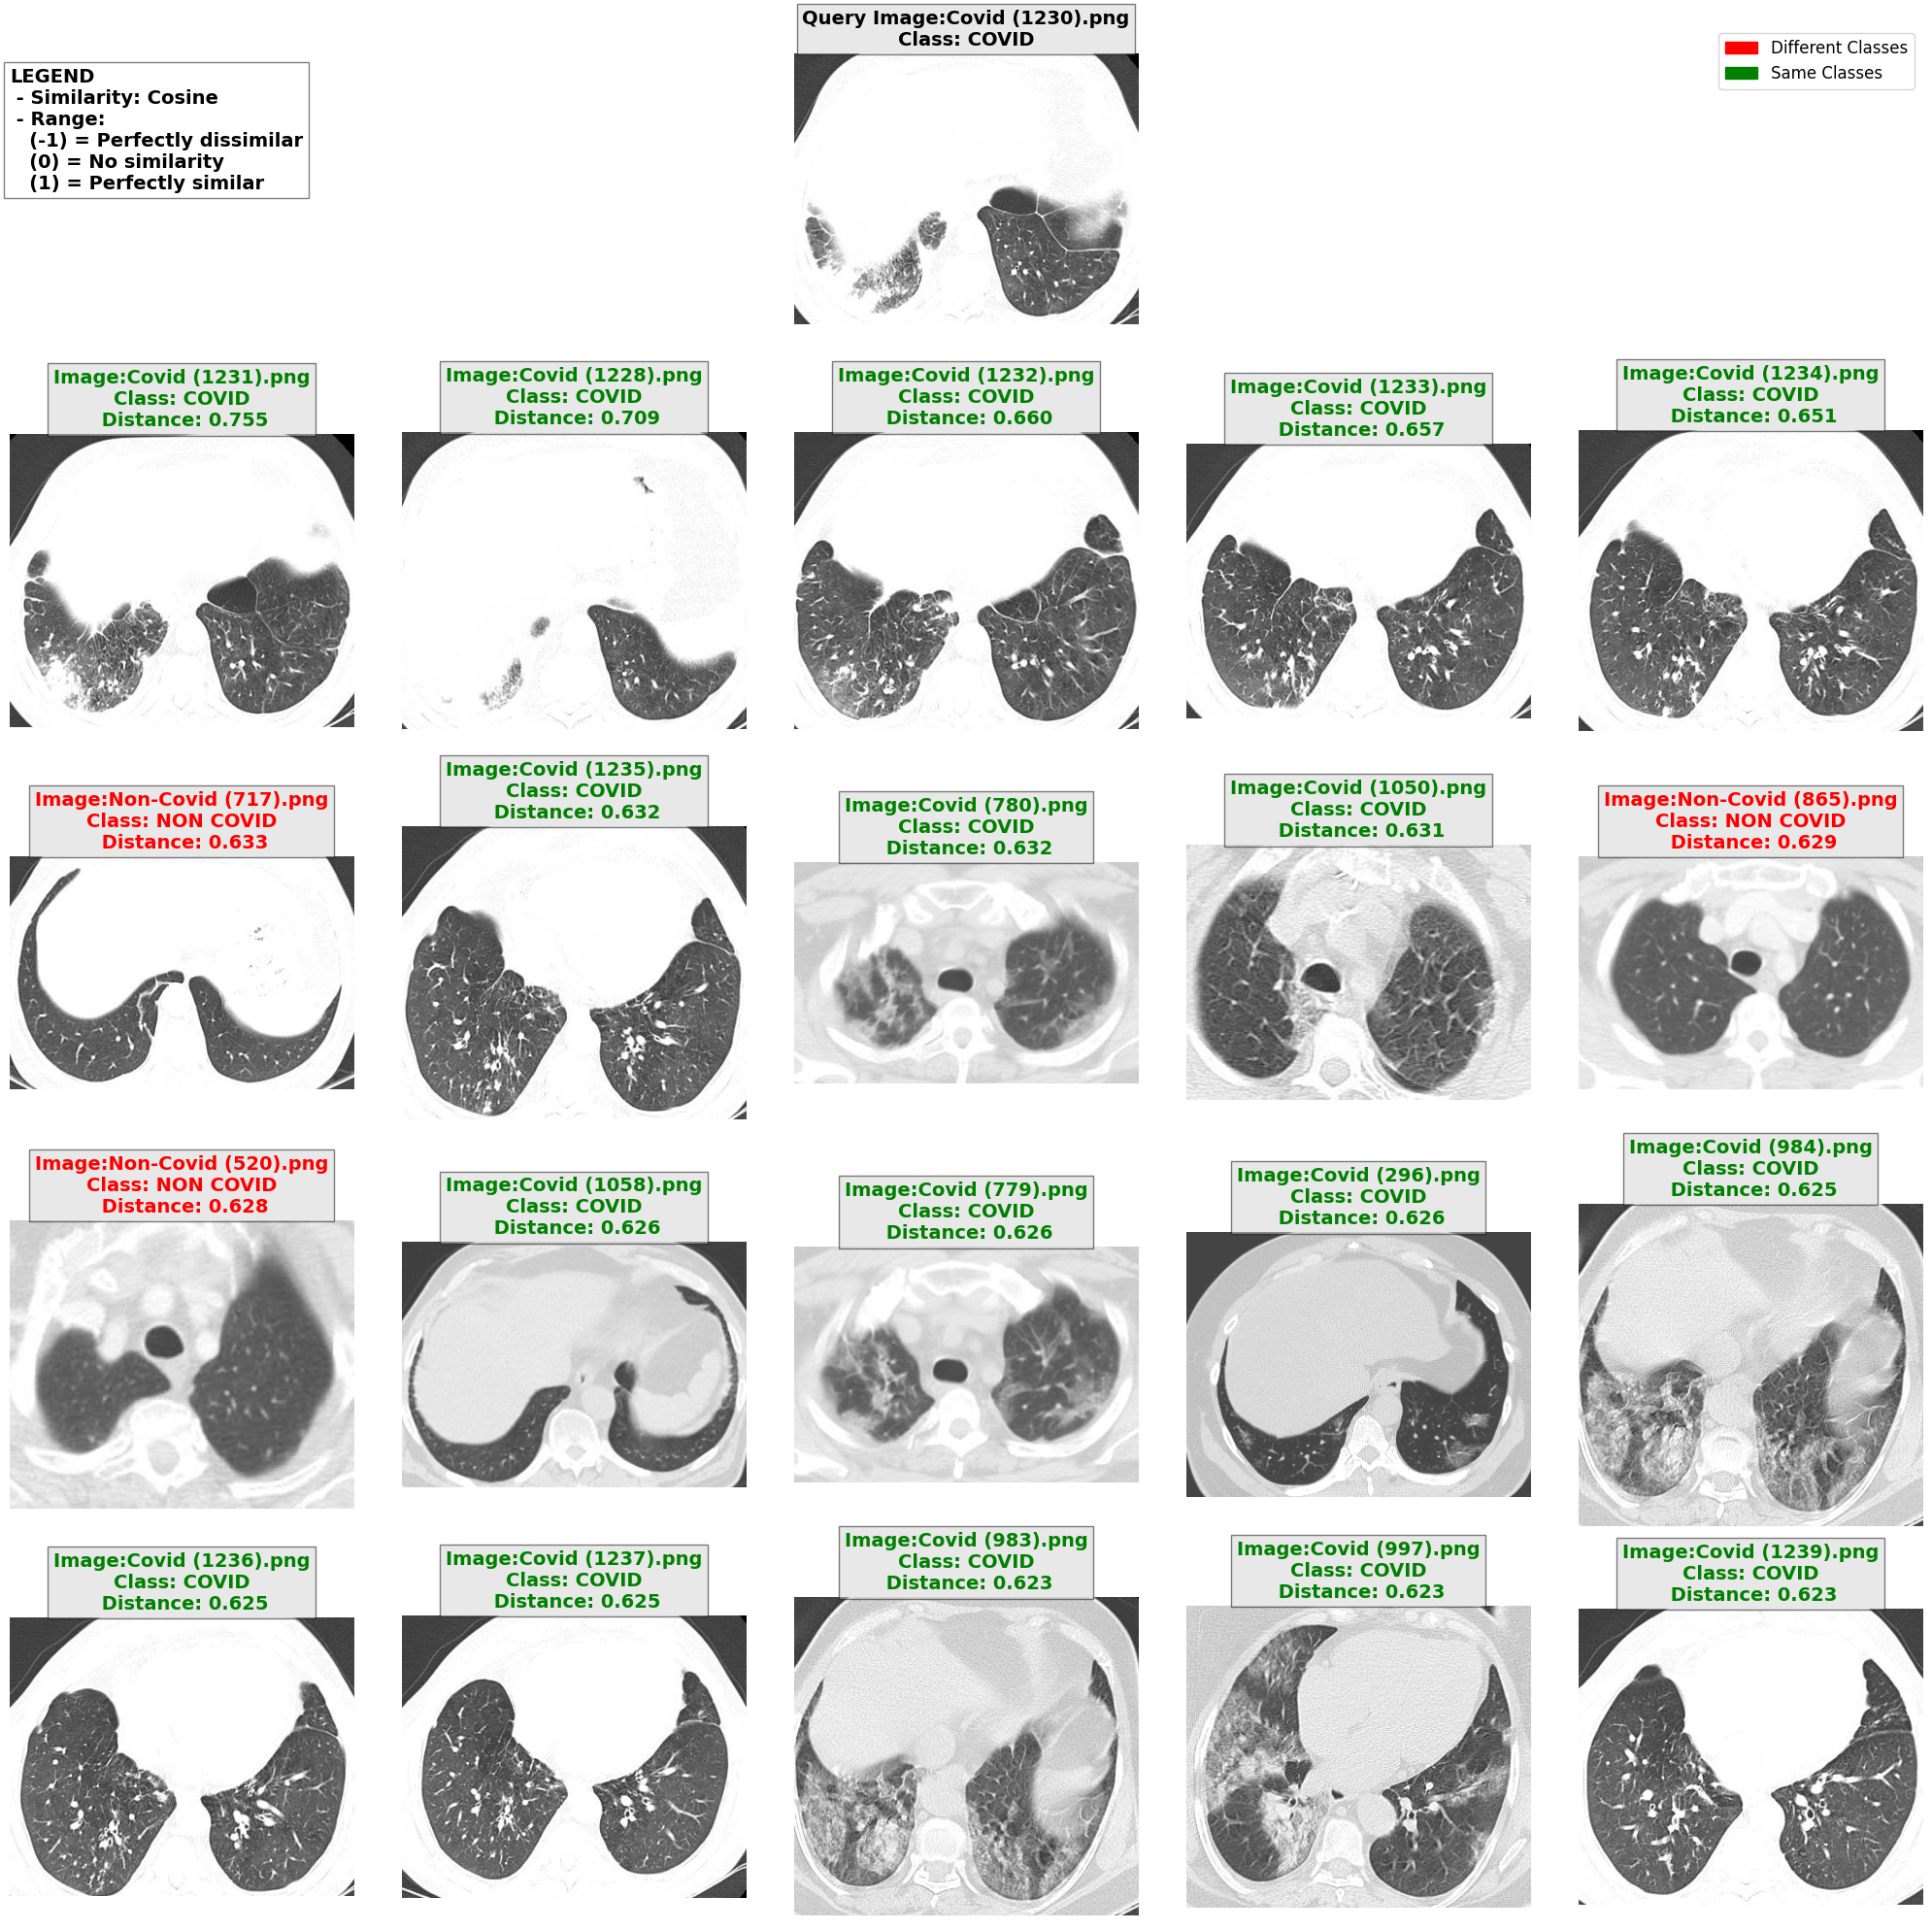

In [10]:
## ************************************ RESNET50 - FROM QUERY FIND SIMILAR ********************************** ##


# Training dataset 
train_dataset = pd.read_json(path_or_buf=RESNET50_TRAIN_JSON)
all_training_features = np.array(train_dataset["features"].to_list())

# Test dataset
test_dataset = pd.read_json(path_or_buf=RESNET50_TEST_JSON)

# To present a more concise and intuitive presentation of the data
# Randomly select 5 samples from each class
selected_class_0 = test_dataset[test_dataset["labels"] == 0].sample(n=5, random_state=19)
selected_class_1 = test_dataset[test_dataset["labels"] == 1].sample(n=5, random_state=19)
# Concatenate the samples -> Test dataset subset with 10 object in total
sample_demo = pd.concat([selected_class_0, selected_class_1])

# Choose a file from the test dataset subset
chosen_file_path, chosen_label, chosen_features = choose_query_file(query_dataset=sample_demo)
# Print info. about query
print(f"\n> Query image: {chosen_file_path}"
      f"\n> Query label: {chosen_label}")

# Compute cosine distances and find similar images
similar_indices, similar_distances = find_top_n_similar_images(features_of_query=chosen_features, all_features=all_training_features)

# Lists of similar image found and corresponding true labels
similar_images = [train_dataset.iloc[index]["file_paths"] for index in similar_indices]
similar_labels = np.array([train_dataset.iloc[index]["labels"] for index in similar_indices])

# Given query -> Plot similar images with class labels and info.
plot_similar_images(path_to_query=chosen_file_path,
                    query_label=chosen_label,
                    similar_image_paths=similar_images,
                    similar_image_labels=similar_labels,
                    distance_measures=similar_distances)


# Evaluation on the entire test set

## Function: `get_average_model_performance`

### Description:
This function evaluates the test dataset by computing precision, recall, and F1-score for each sample. It iterates through each feature in the test dataset, computes cosine similarity to find similar images, evaluates similarity, and computes precision, recall, and F1-score. Finally, it computes the average precision, recall, and F1-score for the entire test dataset.


In [11]:
# Evaluation of the model performance
def evaluate_similarity(query_img_label: int, image_labels_retrieved: np.array, similarity_values: list[float]) -> tuple[float, float, float]:
    """
    Evaluate the similarity between the query image and the Top N most similar images.

    :param query_img_label: Label of the query image.
    :param_ image_labels_retrieved: Labels of the Top-N most similar images retrieved.
    :param similarity_values: cosine similarity values founded between the query image and all other images.

    :return: precision, recall, F1-score.
    """
    # True labels
    ground_truth_labels = []
    for truth_label in image_labels_retrieved:
        if query_img_label == 0:  # COVID
            ground_truth_labels.append(truth_label == 0)
        elif query_img_label == 1:  # non-COVID
            ground_truth_labels.append(truth_label == 1)
    
    # Predicted Labels
    predicted_labels = []
    for similarity_value in similarity_values:
        if similarity_value >= SIMILARITY_THRESHOLD:  # 0.5
            predicted_labels.append(True)
        else:
            predicted_labels.append(False if query_img_label == 0 else True)
    
    # Compute Precision, Recall and F1-score
    precision = precision_score(y_true=ground_truth_labels, y_pred=predicted_labels)
    recall = recall_score(y_true=ground_truth_labels, y_pred=predicted_labels)
    f1 = f1_score(y_true=ground_truth_labels, y_pred=predicted_labels)
    
    return precision, recall, f1


In [12]:
## ************************************ RESNET50 - SINGLE CASE PERFORMANCE EVALUATION ********************************** ##


# Compute precision, recall and f1-score
precision_score_value, recall_score_value, f1_score_value = evaluate_similarity(
    query_img_label=chosen_label, 
    image_labels_retrieved=similar_labels,
    similarity_values=similar_distances
)
# Print info. about chosen query
print(f"\n> Query image: {chosen_file_path}"
      f"\n> Query label: {chosen_label}")

# Print Evaluation scores
print(f"\n> RESNET50 SINGLE CASE PERFORMANCE EVALUATION:")
print(f"-- Precision score: {precision_score_value:.3f}")
print(f"-- Recall score: {recall_score_value:.3f}")
print(f"-- F1-score: {f1_score_value:.3f}")



> Query image: archives/COVID/Covid (1230).png
> Query label: 0

> RESNET50 SINGLE CASE PERFORMANCE EVALUATION:
-- Precision score: 0.850
-- Recall score: 1.000
-- F1-score: 0.919


# Evaluation on the entire test set

## Function: `get_average_model_performance`

### Description:
This function evaluates the test dataset by computing precision, recall, and F1-score for each sample. It iterates through each feature in the test dataset, computes cosine similarity to find similar images, evaluates similarity, and computes precision, recall, and F1-score. Finally, it computes the average precision, recall, and F1-score for the entire test dataset.


In [13]:
# Evaluation performed on all the element of the test set
def get_average_model_performance(query_dataset: pd.DataFrame, training_dataset: pd.DataFrame, all_retrieved_features) -> tuple[float, float, float]:
    """
    Evaluate the test dataset by computing precision, recall, and F1-score and output the average values.

    :param query_dataset: DataFrame containing the test dataset.
    :param training_dataset: DataFrame containing the training dataset.
    :param all_retrieved_features: Retrieved similar features.

    :return: average precision, average recall, and  average f1-score.
    """
    # Initialize lists to store precision, recall, and F1-score for each feature
    precisions = []
    recalls = []
    f1_scores = []
    
    print("\n> Computing classification metrics for each test sample...\n")
    # Iterate through each feature in the test dataset
    for query_file_path, query_label, query_feature in zip(query_dataset["file_paths"], query_dataset["labels"], query_dataset["features"]):
        
        print(f"-- processing: {os.path.basename(query_file_path)}")
        
        # Compute cosine distances and find similar images
        similar_index, similar_distance = find_top_n_similar_images(features_of_query=np.array(query_feature), all_features=all_retrieved_features)

        # Extract labels of similar images
        similar_label = training_dataset.iloc[similar_index]["labels"].to_numpy()

        # Compute precision, recall, and F1-score
        precision, recall, f1 = evaluate_similarity(query_img_label=query_label, image_labels_retrieved=similar_label, similarity_values=similar_distance)

        # Append scores to lists
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
    print("\n> Process completed!")

    # Compute average precision, recall, and F1-score
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1_score = np.mean(f1_scores)
    
    # Load CSV file
    evaluation_file_path = os.path.join(DATA_PATH, f"{resnet50_model.model_name}_evaluation.csv")
    evaluation_df = pd.read_csv(filepath_or_buffer=evaluation_file_path)
    
    # Add new columns to the existing DataFrame
    evaluation_df["mean_precision"] = avg_precision
    evaluation_df["mean_recall"] = avg_recall
    evaluation_df["mean_f1"] = avg_f1_score
    
    # Save the updated DataFrame back to CSV
    evaluation_df.to_csv(evaluation_file_path, index=False, float_format="%.3f")

    return avg_precision, avg_recall, avg_f1_score
    
    
## ************************************ RESNET50 - COMPUTE MODEL PERFORMANCE EVALUATION ********************************** ##


# Compute Average Classification metrics values
average_precision, average_recall, average_f1  = get_average_model_performance(
    query_dataset=test_dataset, 
    training_dataset=train_dataset, 
    all_retrieved_features=all_training_features
)



> Computing classification metrics for each test sample...

-- processing: Non-Covid (1001).png
-- processing: Non-Covid (982).png
-- processing: Covid (1185).png
-- processing: Covid (229).png
-- processing: Non-Covid (460).png
-- processing: Non-Covid (21).png
-- processing: Covid (349).png
-- processing: Covid (683).png
-- processing: Covid (1125).png
-- processing: Non-Covid (111).png
-- processing: Non-Covid (814).png
-- processing: Non-Covid (765).png
-- processing: Covid (716).png
-- processing: Covid (641).png
-- processing: Non-Covid (432).png
-- processing: Non-Covid (760).png
-- processing: Non-Covid (104).png
-- processing: Covid (549).png
-- processing: Non-Covid (505).png
-- processing: Covid (690).png
-- processing: Covid (193).png
-- processing: Covid (792).png
-- processing: Non-Covid (563).png
-- processing: Covid (623).png
-- processing: Non-Covid (409).png
-- processing: Covid (462).png
-- processing: Non-Covid (265).png
-- processing: Covid (231).png
-- processing

In [14]:
# Print average performance
print(f"\n> RESNET50 AVERAGE PERFORMANCE:")
print(f"-- Avg. Precision: {average_precision:.3f}")
print(f"-- Avg. Recall: {average_recall:.3f}")
print(f"-- Avg. F1-score: {average_f1:.3f}")


> RESNET50 AVERAGE PERFORMANCE:
-- Avg. Precision: 0.808
-- Avg. Recall: 1.000
-- Avg. F1-score: 0.882


# Relevance feedback

Implement Relevance feedback

## Function 1: `get_relevant_images_features`

### Description:
This function retrieves the features of similar images with the same label as the chosen file based on the provided indices. It filters the indices to include only those with the same label as the chosen file, retrieves the features, file paths, and labels of similar images, and returns them.

---

## Function 2: `get_irrelevant_images_features`

### Description:
This function retrieves the features of images that are not similar to the query image based on the provided indices. It filters the indices to include only those with a different label from the chosen file, retrieves the features, file paths, and labels of such images, and returns them.

---

## Function 3: `relevance_feedback`

### Description:
This function refines the search based on relevance feedback using Rocchio's algorithm. It adjusts the query features based on the retrieved relevant and irrelevant features using the specified weights (ALPHA, BETA, and GAMMA).


In [15]:
# Get features of images that are similar respect to query
def get_relevant_images_features(closest_indices_to_query: np.array, all_features: np.array(float), 
                                 training_dataset: pd.DataFrame, query_chosen_label: int, quantity=RELEVANT_PICK) -> tuple[np.array(float), np.array(str), np.array(int)]:
    """
    Get the features of similar images with the same label as the chosen file based on the indices provided.

    :param closest_indices_to_query: Indices of the similar images.
    :param all_features: Features of all images in the dataset.
    :param training_dataset: Training DataFrame containing image file paths and labels.
    :param query_chosen_label: Label of the chosen file.
    :param quantity: Define how many "images" get for the process.
        
    :return: similar_images_features: Features of similar images with the same label as the chosen file.
    """
    # Filter the indices to include only those with the same label as the chosen file
    indices_with_same_label = [idx for idx in closest_indices_to_query if training_dataset.iloc[idx]["labels"] == query_chosen_label]
    
    if not indices_with_same_label:
        return None, None, None
    
    number_of_indexes = indices_with_same_label[:quantity]
    
    # Get features, file paths, and labels of similar images with the same label
    relevant_images_features = all_features[number_of_indexes]
    relevant_images_paths = [os.path.basename(path) for path in training_dataset.iloc[number_of_indexes]["file_paths"]]
    relevant_images_labels = training_dataset.iloc[number_of_indexes]["labels"].tolist()
    
    return relevant_images_features, relevant_images_paths, relevant_images_labels


# Get features of images that are not similar respect to query
def get_irrelevant_images_features(closest_indices_to_query: np.array, all_features: np.array(float), 
                                   training_dataset: pd.DataFrame, query_chosen_label: int, quantity=IRRELEVANT_PICK) -> tuple[np.array(float), np.array(str), np.array(int)]:
    """
    Get the features of irrelevant (not similar) images with the same label as the chosen file based on the indices provided.

    :param closest_indices_to_query: Indices of the retrieved images.
    :param all_features: Features of all images in the dataset.
    :param training_dataset: Training DataFrame containing image file paths and labels.
    :param query_chosen_label: Label of the chosen file.
    :param quantity: Define how many images should be considered.
        
    :return: irrelevant_images_features: Features of similar images with the same label as the chosen file; 
    irrelevant_images_paths: Paths of the images considered; irrelevant_images_labels: Labels of the images considered.
    """
    # Filter the indices to include only those with the different label as the chosen file
    indices_with_same_label = [idx for idx in closest_indices_to_query if training_dataset.iloc[idx]["labels"] != query_chosen_label]
    
    if not indices_with_same_label:
        return None, None, None
    
    number_of_indexes = indices_with_same_label[:quantity]
    irrelevant_images_features = all_features[number_of_indexes]
    irrelevant_images_paths = [os.path.basename(path) for path in training_dataset.iloc[number_of_indexes]["file_paths"]]
    irrelevant_images_labels = training_dataset.iloc[number_of_indexes]["labels"].tolist()
    
    # Get features, file paths, and labels of similar images with the same label
    return irrelevant_images_features, irrelevant_images_paths, irrelevant_images_labels
    

# Relevance Feedback improvements
def relevance_feedback(query_features: np.array(float), 
                       relevant_features_retrieved: np.array(float), irrelevant_features_retrieved: np.array(float)) -> np.array(float):
    """
    Refine the search based on relevance feedback using Rocchio's algorithm.

    :param query_features: Features of the query image.
    :param relevant_features_retrieved: Features of relevant images.
    :param irrelevant_features_retrieved: Features of irrelevant images.

    :return: updated_query_features: new updated features.
    """
    # Check if there are no relevant or irrelevant features retrieved
    if relevant_features_retrieved is None or irrelevant_features_retrieved is None:
        return np.array(query_features)

    # Compute the centroid of the relevant features
    relevant_centroid = np.mean(relevant_features_retrieved, axis=0)
    
    # Compute the centroid of the irrelevant features
    irrelevant_centroid = np.mean(irrelevant_features_retrieved, axis=0)

    # Adjust the query features using Rocchio's algorithm
    updated_query_features = ALPHA * query_features + BETA * relevant_centroid - GAMMA * irrelevant_centroid
    
    return np.array(updated_query_features)



> Query image: archives/COVID/Covid (1230).png
> Query label: 0

> Relevant images: ['Covid (1231).png', 'Covid (1228).png', 'Covid (1232).png', 'Covid (1233).png', 'Covid (1234).png'] - Labels: [0, 0, 0, 0, 0]

> Irrelevant images: ['Non-Covid (717).png', 'Non-Covid (865).png', 'Non-Covid (520).png'] - Labels: [1, 1, 1]


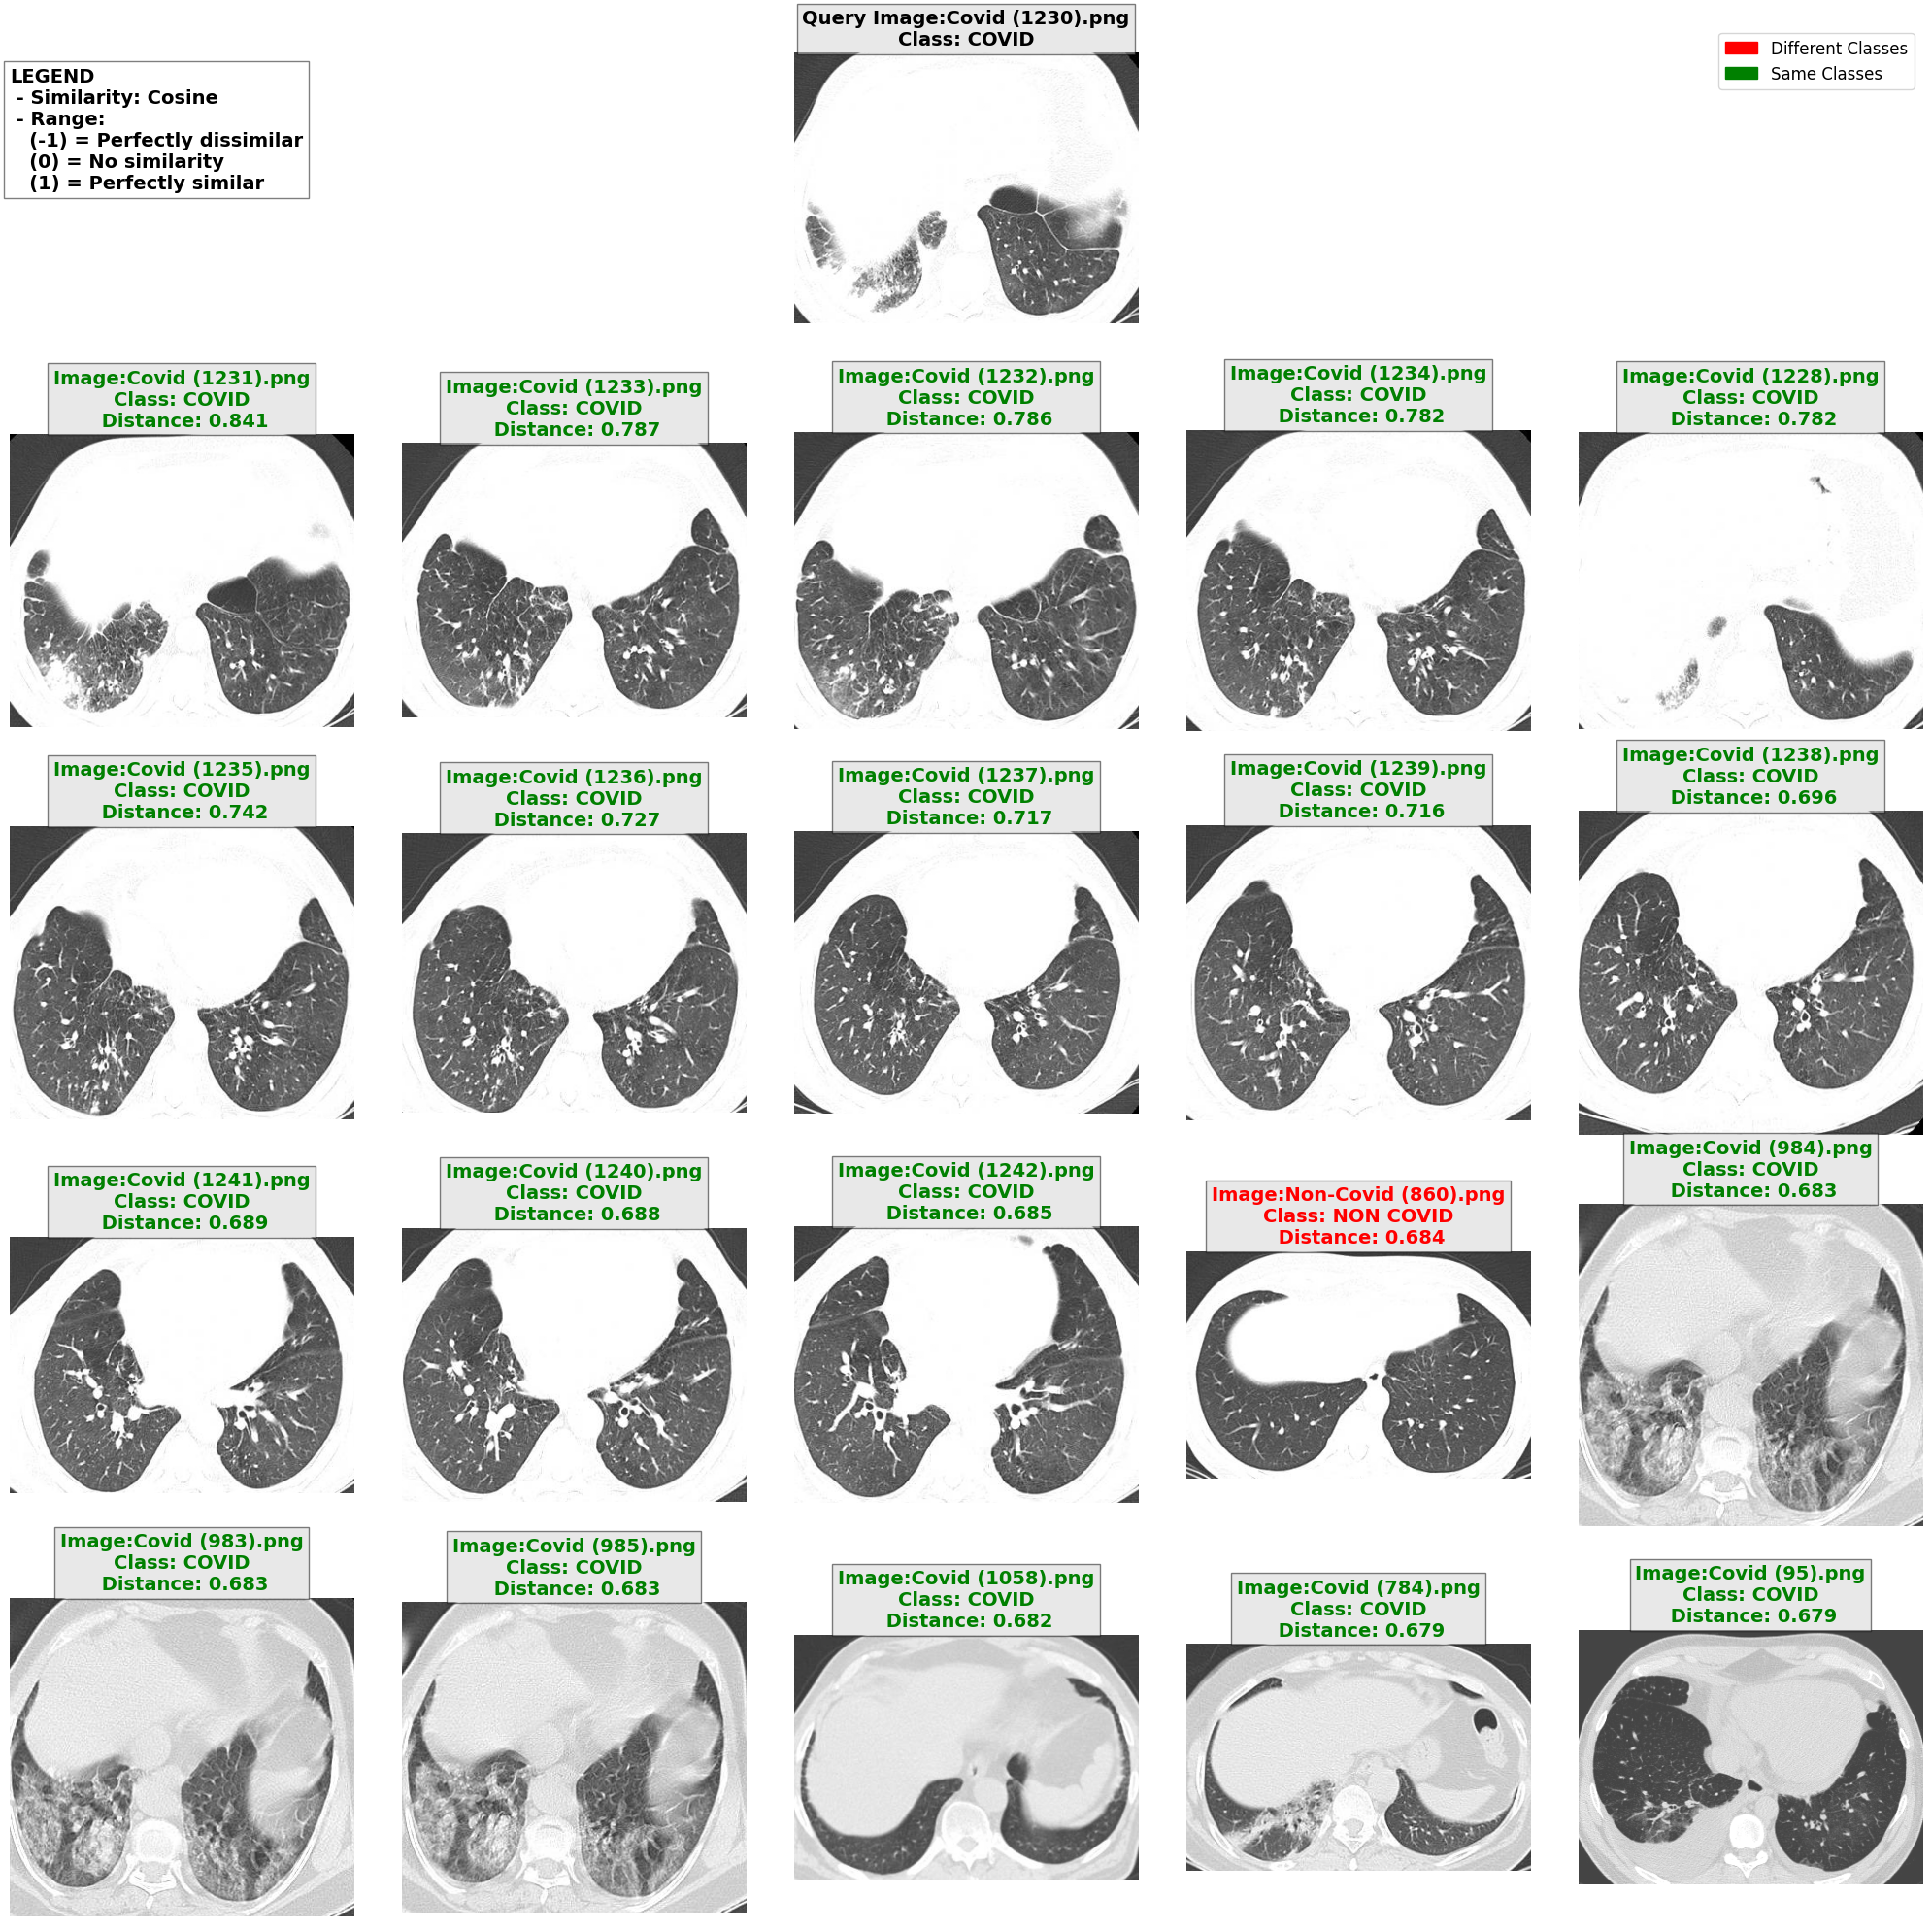

In [16]:
## ************************************ RESNET50 - FROM QUERY FIND SIMILAR - WITH RELEVANCE FEEDBACK ********************************** ##


# Print info. about query
print(f"\n> Query image: {chosen_file_path}"
      f"\n> Query label: {chosen_label}")

# Get the features related to the first three image retrieved 
relevant_features, relevant_paths, relevant_labels  = get_relevant_images_features(
    closest_indices_to_query=similar_indices,
    all_features=all_training_features, 
    training_dataset=train_dataset, 
    query_chosen_label=chosen_label
)
# Print paths and labels of relevant images 
print(f"\n> Relevant images: {relevant_paths} - Labels: {relevant_labels}")

irrelevant_features, irrelevant_paths, irrelevant_labels = get_irrelevant_images_features(
    closest_indices_to_query=similar_indices,
    all_features=all_training_features, 
    training_dataset=train_dataset, 
    query_chosen_label=chosen_label
)
# Print paths and labels of irrelevant images 
print(f"\n> Irrelevant images: {irrelevant_paths} - Labels: {irrelevant_labels}")


# New features
new_features = relevance_feedback(query_features=chosen_features, 
                                  relevant_features_retrieved=relevant_features, 
                                  irrelevant_features_retrieved=irrelevant_features)

# Find similar images with the new features
relevant_indices, relevant_distances = find_top_n_similar_images(features_of_query=new_features, all_features=all_training_features)

# Lists of similar image found and corresponding true labels
refined_similar_images = [train_dataset.iloc[index]["file_paths"] for index in relevant_indices]
refined_similar_labels = np.array([train_dataset.iloc[index]["labels"] for index in relevant_indices])

# Given query -> Plot similar images with class labels and info.
plot_similar_images(path_to_query=chosen_file_path, 
                    query_label=chosen_label, 
                    similar_image_paths=refined_similar_images,
                    similar_image_labels=refined_similar_labels, 
                    distance_measures=relevant_distances,
                    is_relevance=True)


In [17]:
## ************************************ RESNET50 - SINGLE CASE PERFORMANCE EVALUATION - WITH RELEVANCE FEEDBACK ********************************** ##


# Find similar images with the new features
relevant_indices, relevant_distances = find_top_n_similar_images(features_of_query=new_features, all_features=all_training_features)
# Corresponding true labels of the similar images found (TOP_N)
refined_similar_labels = np.array([train_dataset.iloc[index]["labels"] for index in relevant_indices])

# Single case evaluation after Relevance Feedback
relevant_precision, relevant_recall, relevant_f1 = evaluate_similarity(
    query_img_label=chosen_label, 
    image_labels_retrieved=refined_similar_labels,
    similarity_values=relevant_distances
)

# Print info. about query
print(f"\n> Query image: {chosen_file_path}"
      f"\n> Query label: {chosen_label}")

# Print Evaluation scores
print(f"\n> RESNET50 SINGLE CASE PERFORMANCE EVALUATION WITH RELEVANCE FEEDBACK:")
print(f"-- Precision score: {relevant_precision:.3f}")
print(f"-- Recall score: {relevant_recall:.3f}")
print(f"-- F1-score: {relevant_f1:.3f}")



> Query image: archives/COVID/Covid (1230).png
> Query label: 0

> RESNET50 SINGLE CASE PERFORMANCE EVALUATION WITH RELEVANCE FEEDBACK:
-- Precision score: 0.950
-- Recall score: 1.000
-- F1-score: 0.974


# Evaluation on the entire set with relevance feedback
 
## Function: `evaluation_after_relevance_feedback`

### Description:
This function performs an evaluation on the test dataset by computing precision, recall, and F1-score for each feature after performing relevance feedback. It iterates through each feature in the test dataset, computes cosine similarity to find similar images, performs relevance feedback, computes precision, recall, and F1-score with the new features, and computes the average precision, recall, and F1-score for the entire test dataset.


In [18]:
# Evaluation performed on all the element of the test set, performing relevance feedback 
def evaluation_after_relevance_feedback(query_dataset: pd.DataFrame, training_dataset: pd.DataFrame, all_retrieved_features) -> tuple[float, float, float]:
    """
    Evaluation on the test dataset by computing precision, recall, and F1-score for each feature 
    and output the average of them.

    :param query_dataset: DataFrame containing the test dataset.
    :param training_dataset: DataFrame containing the training dataset.
    :param all_retrieved_features: Retrieved similar features.

    :return: Average precision, recall, and F1-score.
    """
    # Initialize lists to store precision, recall, and F1-score for each feature
    precisions = []
    recalls = []
    f1_scores = []
    
    print("\n> Computing classification metrics...")
    # Iterate through each feature in the test dataset
    for query_file_path, query_label, query_feature in zip(query_dataset["file_paths"], query_dataset["labels"], query_dataset["features"]):
        
        print(f"- Processing file: {os.path.basename(query_file_path)}, label: {query_label}")
        
        # Compute cosine distances and find similar images
        old_similar_indices, _ = find_top_n_similar_images(features_of_query=np.array(query_feature), all_features=all_retrieved_features)
        
        # Get the similar images' features
        relevant_similar_features, relevant_similar_paths, relevant_similar_labels = get_relevant_images_features(
            closest_indices_to_query=old_similar_indices, 
            all_features=all_retrieved_features, 
            training_dataset=train_dataset, 
            query_chosen_label=query_label,
        )
        # Print paths and labels of relevant images 
        print(f"-- Relevant images: {relevant_similar_paths} - Labels: {relevant_similar_labels}")
        
        # Get the similar images' features
        irrelevant_similar_features, irrelevant_similar_paths, irrelevant_similar_labels = get_irrelevant_images_features(
            closest_indices_to_query=old_similar_indices, 
            all_features=all_retrieved_features, 
            training_dataset=train_dataset, 
            query_chosen_label=query_label,
        )
        # Print paths and labels of relevant images 
        print(f"-- Irrelevant images: {irrelevant_similar_paths} - Labels: {irrelevant_similar_labels}\n")
        
        # Perform Relevant feedback
        relevance_features = relevance_feedback(
            query_features=query_feature, 
            relevant_features_retrieved=relevant_similar_features, 
            irrelevant_features_retrieved=irrelevant_similar_features
        )
        
        # Find similar images with the new features
        new_similar_indices, new_similar_distance = find_top_n_similar_images(features_of_query=relevance_features, all_features=all_training_features)

        # Extract labels of similar images
        new_similar_labels = training_dataset.iloc[new_similar_indices]["labels"].to_numpy()

        # Compute precision, recall, and F1-score
        precision, recall, f1 = evaluate_similarity(query_img_label=query_label, image_labels_retrieved=new_similar_labels, similarity_values=new_similar_distance)

        # Append scores to lists
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    print("> Process completed!")

    # Compute average precision, recall, and F1-score
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1_score = np.mean(f1_scores)
    
    # Load CSV file
    evaluation_file_path = os.path.join(DATA_PATH, f"{resnet50_model.model_name}_evaluation.csv")
    evaluation_df = pd.read_csv(filepath_or_buffer=evaluation_file_path)
    
    # Add new columns to the existing DataFrame
    evaluation_df["mean_relevant_precision"] = avg_precision
    evaluation_df["mean_relevant_recall"] = avg_recall
    evaluation_df["mean_relevant_f1"] = avg_f1_score
    
    # Save the updated DataFrame back to CSV
    evaluation_df.to_csv(evaluation_file_path, index=False, float_format="%.3f")

    return avg_precision, avg_recall, avg_f1_score

In [ ]:
# Perform Evaluation after Relevant Feedback
avg_relevant_precision, avg_relevant_recall, avg_relevant_f1_score = evaluation_after_relevance_feedback(
    query_dataset=test_dataset, 
    training_dataset=train_dataset, 
    all_retrieved_features=all_training_features
)


In [20]:
# Print Average Evaluation scores
print(f"\n> RESNET50 AVERAGE PERFORMANCE WITH RELEVANCE FEEDBACK:")
print(f"-- Avg. Precision: {avg_relevant_precision:.3f}")
print(f"-- Avg. Recall: {avg_relevant_recall:.3f}")
print(f"-- Avg. F1-score: {avg_relevant_f1_score:.3f}")


> RESNET50 AVERAGE PERFORMANCE WITH RELEVANCE FEEDBACK:
-- Avg. Precision: 0.887
-- Avg. Recall: 1.000
-- Avg. F1-score: 0.931
